In [75]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append('../')

# Graph imports
import src.graph as graph
import src.estimator as estimator
import src.utils as utils

# usual imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import gc
import random
import networkx as nx

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix



np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the graph

In [2]:
# beta should be higher than c
n = 1000 # number of nodes - 585 similar to c elegans
p = 0  # number of neighbouts to take into account

alpha = -0.03    #  negative 0.003
beta  = -0.04    #  negative the higher the more concentrated will be the edges into a single vertex 0.003
sigma = np.log(1/1e-2 - 1)    # intercept the higher the harder for creating edges 6

threshold   = 0.5
n_iteration = 10
warm_up     = 5

################################################
params_dict = {
    "n": n,
    "p": p,
    "alpha": alpha,
    "beta": beta,
    "sigma": sigma,
    "threshold": threshold,
    "n_iteration": n_iteration,
    "warm_up": warm_up
}

In [3]:
ut  = utils.GraphUtils()
#graphs, spectra = ut.loading_graph_artifacts(params_dict)

# Estimation with MLE

In [ ]:
g = graphs[-1]
s = spectra[-1]

In [ ]:
ut.plot_graph_from_adjacency(g, pos=None, title='Graph', size=(10,5))

In [ ]:
ut.plot_degree_distribution(g, title='Degree Distribution', size=(5,2))

In [ ]:
initial_guess = [0,0,0]
est = estimator.MLEGraphModelEstimator(g)

a_hat, b_hat, s_hat = est.estimate_parameters_torch(initial_guess=initial_guess, learning_rate=0.001, max_iter=30)

In [ ]:
print(a_hat,b_hat,s_hat)
print(alpha, beta, sigma)

## Plot

In [ ]:
c_values = np.linspace(0.000001, 2, 100)
beta_values = np.linspace(0.000001, 2, 100)

likelihood = np.empty((len(c_values), len(beta_values)))
for i, ci in enumerate(c_values):
    for j, betaj in enumerate(beta_values):
        likelihood[i, j] = est.likelihood_function([ci, betaj])


In [ ]:
params_history = np.array([initial_guess]+est.params_history)

# Convert the parameters to the corresponding indices in the c_values and beta_values arrays
c_indices = params_history[:, 0]
beta_indices = params_history[:, 1]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the full heatmap on the first subplot
im = axs[0].imshow(likelihood, origin='lower', extent=[c_values[0], c_values[-1], beta_values[0], beta_values[-1]], aspect='auto')
fig.colorbar(im, ax=axs[0], label='Likelihood')
axs[0].scatter(c_indices, beta_indices, color='red', s=1)  # Change color as needed
for i in range(1, len(c_indices)):
    axs[0].arrow(c_indices[i-1], beta_indices[i-1], c_indices[i]-c_indices[i-1], beta_indices[i]-beta_indices[i-1], 
              shape='full', color='green', lw=1.5, length_includes_head=True, head_width=0.006)
axs[0].set_xlabel('c')
axs[0].set_ylabel('beta')
axs[0].set_title('Likelihood function')

# Plot a zoomed in region on the second subplot
zoom_c_min, zoom_c_max = 0, 0.7  # Adjust these values to zoom in on the desired region
zoom_beta_min, zoom_beta_max = 0, 1.1  # Adjust these values to zoom in on the desired region
im_zoom = axs[1].imshow(likelihood, origin='lower', extent=[c_values[0], c_values[-1], beta_values[0], beta_values[-1]], aspect='auto')
fig.colorbar(im_zoom, ax=axs[1], label='Likelihood')
axs[1].scatter(c_indices, beta_indices, color='red', s=1)  # Change color as needed
for i in range(1, len(c_indices)):
    axs[1].arrow(c_indices[i-1], beta_indices[i-1], c_indices[i]-c_indices[i-1], beta_indices[i]-beta_indices[i-1], 
              shape='full', color='green', lw=1.5, length_includes_head=True, head_width=0.006)
axs[1].set_xlim(zoom_c_min, zoom_c_max)
axs[1].set_ylim(zoom_beta_min, zoom_beta_max)
axs[1].set_xlabel('c')
axs[1].set_ylabel('beta')
axs[1].set_title('Zoomed in likelihood function')

plt.tight_layout()
plt.show()

# Estimation with regression 

In [62]:
# beta should be higher than c
n = 400 # number of nodes - 585 similar to c elegans
p = 0  # number of neighbouts to take into account

alpha = 0.2    #  negative 0.003
beta  = 0.1    #  negative the higher the more concentrated will be the edges into a single vertex 0.003
sigma = np.log(1/1e-2 - 1)    # intercept the higher the harder for creating edges 6

threshold   = 0.5
n_iteration = 20
warm_up     = 1

################################################
params_dict = {
    "n": n,
    "p": p,
    "alpha": alpha,
    "beta": beta,
    "sigma": sigma,
    "threshold": threshold,
    "n_iteration": n_iteration,
    "warm_up": warm_up
}

In [63]:
graph_model = graph.GraphModel(n=n, p=p, alpha=alpha, beta=beta, sigma=sigma, threshold=threshold, n_iteration=n_iteration, warm_up=warm_up)
graphs, spec = graph_model.populate_edges( warm_up = warm_up, max_iterations = n_iteration, stability_window=5, degree_dist_threshold=0.1)

iteration: 0
iteration: 1
iteration: 2
Not enough graphs for stability check.
iteration: 3
Not enough graphs for stability check.
iteration: 4
KS Statistic: 0.1625
Degree Distribution Stable: False
Graph Converged: False




iteration: 5
KS Statistic: 0.1
Degree Distribution Stable: False
Graph Converged: False




iteration: 6
KS Statistic: 0.085
KS Statistic: 0.1
Degree Distribution Stable: False
Graph Converged: False




iteration: 7
KS Statistic: 0.06
KS Statistic: 0.085
KS Statistic: 0.1
Degree Distribution Stable: False
Graph Converged: False




iteration: 8
KS Statistic: 0.0225
KS Statistic: 0.06
KS Statistic: 0.085
KS Statistic: 0.1
Degree Distribution Stable: False
Graph Converged: False




iteration: 9
KS Statistic: 0.0375
KS Statistic: 0.0225
KS Statistic: 0.06
KS Statistic: 0.085
Degree Distribution Stable: True
Graph Converged: True






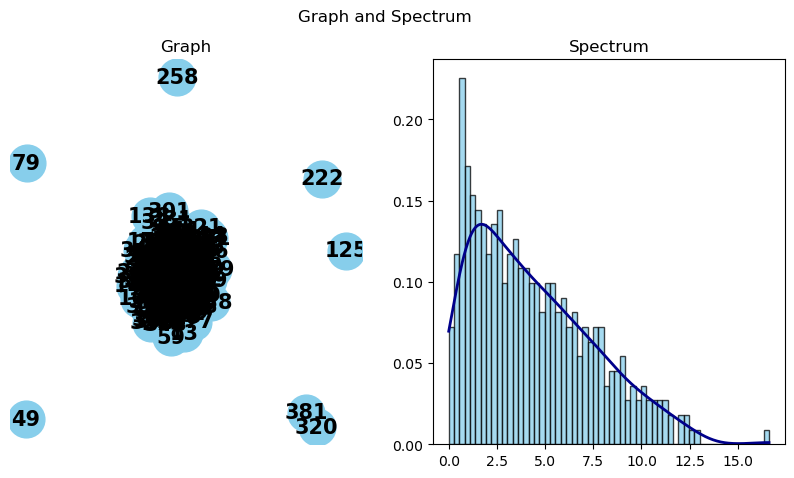

In [86]:
g = graphs[-1]
s = spec[-1]
G = nx.Graph(g)
ut = utils.GraphUtils()     
fig = ut.plot_graph_and_spectrum(g, s, title='Graph and Spectrum', size=(10,5))
#ut.plot_degree_distribution(g, title='Degree Distribution', size=(5,2))
fig 

In [76]:
est = estimator.LogitRegEstimator2(g)


In [84]:
params, pvalue = est.estimate_parameters(l1_wt=1, alpha=0.1)
params, sigma, alpha, beta

                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.049      
Date:               2024-04-18 09:44 AIC:              9105.0943  
No. Observations:   79800            BIC:              9132.9561  
Df Model:           2                Log-Likelihood:   -4549.5    
Df Residuals:       79797            LL-Null:          -4783.1    
Converged:          1.0000           LLR p-value:      3.8802e-102
No. Iterations:     24.0000          Scale:            1.0000     
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const     -6.5387     0.1079   -60.6005   0.0000   -6.7502   -6.3272
x1         0.1881     0.0123    15.2972   0.0000    0.1640    0.2122
x2         0.2246     0.0136    16.4910   0.0000    0.1979    0.2513



/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 2 out of 3 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


(array([-6.53871714,  0.18811731,  0.22464823]), 4.59511985013459, 0.2, 0.1)

In [9]:
params_dict

{'n': 1000,
 'p': 0,
 'alpha': -0.03,
 'beta': -0.04,
 'sigma': 4.59511985013459,
 'threshold': 0.5,
 'n_iteration': 1,
 'warm_up': 1}

In [12]:
n_runs = 20
params_list = []
for i in range(n_runs):
    graph_model = graph.GraphModel(n=n, p=p, alpha=alpha, beta=beta, sigma=sigma, threshold=threshold, n_iteration=n_iteration, warm_up=warm_up)
    graphs, _ = graph_model.populate_edges( warm_up = warm_up, max_iterations = n_iteration)
    g = graphs[-1]
    import gc
    del graphs
    gc.collect

    est = estimator.LogitRegEstimator2(g)
    params, pvalue = est.estimate_parameters()
    params_list.append(params)

    import pickle
    with open(f'runs/results_array2_{i}.pkl', 'wb') as f:
        pickle.dump(params_list, f)



iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
KS Statistic: 0.0
KS Statistic: 0.905
Degree Distribution Stable: False
Graph Converged: False




iteration: 7
KS Statistic: 0.0
KS Statistic: 0.0
KS Statistic: 0.905
Degree Distribution Stable: False
Graph Converged: False




iteration: 8
KS Statistic: 0.0
KS Statistic: 0.0
KS Statistic: 0.0
KS Statistic: 0.905
Degree Distribution Stable: False
Graph Converged: False




iteration: 9
KS Statistic: 0.0
KS Statistic: 0.0
KS Statistic: 0.0
KS Statistic: 0.0
Degree Distribution Stable: True
Graph Converged: True






/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter ma

LinAlgError: Singular matrix